In [1]:
import pandas as pd
import xgboost as xgb

# Cargar el dataset
df = pd.read_csv('../data/ventas_feature1.csv', sep=',')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 31 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   periodo                    int32   
 1   customer_id                int64   
 2   product_id                 int64   
 3   plan_precios_cuidados      float64 
 4   tn                         float64 
 5   cust_request_qty           float64 
 6   cust_request_tn            float64 
 7   cat1                       category
 8   cat2                       category
 9   cat3                       category
 10  brand                      category
 11  sku_size                   int64   
 12  descripcion                category
 13  productos_estrella         int64   
 14  mes                        int64   
 15  catastrofe                 int64   
 16  cliente_estrella           int64   
 17  prod_cust                  category
 18  tn_lag_1                   float64 
 19  tn_lag_2           

In [2]:
import random
import numpy as np

SEED = 26461180
random.seed(SEED)
np.random.seed(SEED)

# Convertir 'periodo' de fecha a entero tipo YYYYMM
df["periodo"] = pd.to_datetime(df["periodo"])
df["periodo"] = df["periodo"].dt.strftime("%Y%m").astype(int)


In [3]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,tn_lag_4,tn_lag_5,tn_mas_2,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
0,201701,10001,20001,0.0,99.43861,11.0,99.43861,HC,ROPA LAVADO,Liquido,...,NaN,NaN,143.49426,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
1,201701,10002,20001,0.0,35.72806,17.0,38.68301,HC,ROPA LAVADO,Liquido,...,NaN,NaN,184.72927,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
2,201701,10003,20001,0.0,143.49426,17.0,143.49426,HC,ROPA LAVADO,Liquido,...,NaN,NaN,19.08407,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
3,201701,10004,20001,0.0,184.72927,9.0,184.72927,HC,ROPA LAVADO,Liquido,...,NaN,NaN,43.83179,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
4,201701,10005,20001,0.0,19.08407,23.0,19.08407,HC,ROPA LAVADO,Liquido,...,99.43861,NaN,65.12087,101.5859,1.59,24.8,15.91,25.65,30.4,20.9


In [4]:
# 1. Crear dataset de entrenamiento
df_train = df.copy()
df_train2 = df.copy()

In [5]:
df_train.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,tn_lag_4,tn_lag_5,tn_mas_2,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
0,201701,10001,20001,0.0,99.43861,11.0,99.43861,HC,ROPA LAVADO,Liquido,...,NaN,NaN,143.49426,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
1,201701,10002,20001,0.0,35.72806,17.0,38.68301,HC,ROPA LAVADO,Liquido,...,NaN,NaN,184.72927,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
2,201701,10003,20001,0.0,143.49426,17.0,143.49426,HC,ROPA LAVADO,Liquido,...,NaN,NaN,19.08407,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
3,201701,10004,20001,0.0,184.72927,9.0,184.72927,HC,ROPA LAVADO,Liquido,...,NaN,NaN,43.83179,101.5859,1.59,24.8,15.91,25.65,30.4,20.9
4,201701,10005,20001,0.0,19.08407,23.0,19.08407,HC,ROPA LAVADO,Liquido,...,99.43861,NaN,65.12087,101.5859,1.59,24.8,15.91,25.65,30.4,20.9


In [6]:
df["periodo"] = df["periodo"].astype(int)

In [7]:
# Convierte todas las columnas object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')


In [8]:
X_train = df_train2.drop(columns=["tn", "periodo", "descripcion", "prod_cust"], errors="ignore")
y_train = df_train["tn"]

# 2. Generar dataset de predicción para 202002
# Tomamos los registros de 201912 como base y simulamos las features
df_201912 = df[df["periodo"] == 201912].copy()
df_pred = df_201912.copy()
df_pred["periodo"] = 202002  # Simulamos el período futuro

In [9]:
df_pred.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,tn_lag_4,tn_lag_5,tn_mas_2,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
20895,202002,10001,20001,0.0,180.21938,18.0,214.72185,HC,ROPA LAVADO,Liquido,...,0.00000,0.0,102.27517,283.4442,3.74,53.83,59.88,24.0,29.5,18.0
20896,202002,10002,20001,0.0,113.33165,20.0,115.30322,HC,ROPA LAVADO,Liquido,...,0.00000,0.0,34.64810,283.4442,3.74,53.83,59.88,24.0,29.5,18.0
20897,202002,10003,20001,0.0,102.27517,9.0,113.98137,HC,ROPA LAVADO,Liquido,...,0.00000,0.0,19.60368,283.4442,3.74,53.83,59.88,24.0,29.5,18.0
20898,202002,10004,20001,0.0,34.64810,8.0,34.64810,HC,ROPA LAVADO,Liquido,...,0.00000,0.0,20.70148,283.4442,3.74,53.83,59.88,24.0,29.5,18.0
20899,202002,10005,20001,0.0,19.60368,25.0,19.60368,HC,ROPA LAVADO,Liquido,...,180.21938,0.0,109.55654,283.4442,3.74,53.83,59.88,24.0,29.5,18.0


In [10]:
cat_cols = ["cat1", "cat2", "cat3", "brand"]
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("category")

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 27 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   customer_id                int64   
 1   product_id                 int64   
 2   plan_precios_cuidados      float64 
 3   cust_request_qty           float64 
 4   cust_request_tn            float64 
 5   cat1                       category
 6   cat2                       category
 7   cat3                       category
 8   brand                      category
 9   sku_size                   int64   
 10  productos_estrella         int64   
 11  mes                        int64   
 12  catastrofe                 int64   
 13  cliente_estrella           int64   
 14  tn_lag_1                   float64 
 15  tn_lag_2                   float64 
 16  tn_lag_3                   float64 
 17  tn_lag_4                   float64 
 18  tn_lag_5                   float64 
 19  tn_mas_2           

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# # Subsample del dataset para que no explote (¡no uses los 16M en GridSearch!)
# X_sample = X_train.sample(n=100_000, random_state=SEED)
# y_sample = y_train.loc[X_sample.index]

# param_grid = {
#     "max_depth": [4, 6, 8],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "n_estimators": [50, 100, 200],
#     "subsample": [0.5, 0.8, 1.0],
#     "colsample_bytree": [0.5, 0.8, 1.0],
#     "gamma": [0, 0.1, 0.2],
#     "reg_alpha": [0, 0.1, 0.5],
# }

# model = XGBRegressor(enable_categorical=True, n_jobs=-1)

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring="neg_root_mean_squared_error",
#     cv=3,
#     verbose=1
# )

# grid_search.fit(X_sample, y_sample)

# print("✅ Mejor combinación:", grid_search.best_params_)
# print("📉 Mejor score (RMSE negativo):", grid_search.best_score_)


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
✅ Mejor combinación: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.5, 'subsample': 0.5}
📉 Mejor score (RMSE negativo): -0.5136559475386585


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor

categorical_cols = ['cat1','cat2','cat3','brand']

X_sample = X_train.sample(n=500_000, random_state=SEED)
for c in categorical_cols:
    X_sample[c] = X_sample[c].astype('category').cat.codes
    
y_sample = y_train.loc[X_sample.index]

tscv = TimeSeriesSplit(n_splits=10)

xgb_model = XGBRegressor(
    tree_method='gpu_hist',  # Usar GPU si está disponible
    predictor='gpu_predictor',
    objective='reg:squarederror',
    random_state=SEED,
    n_jobs=-1,  # Usar todos los núcleos disponibles
    enable_categorical=True
)


param_dist = {
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 8]
}

rs = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=SEED,
    verbose=2,
    n_jobs=-1
)


In [ ]:
# Ejecutar búsqueda
rs.fit(X_sample, y_sample)

# Resultados
top_params = rs.best_params_
best_rmse = rs.best_score_
print("✅ Mejores hiperparámetros:", top_params)
print(f"📉 Mejor RMSE: {best_rmse:.4f}")

In [14]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor

categorical_cols = ['cat1','cat2','cat3','brand']
X_sample = X_train.sample(n=500_000, random_state=SEED).copy()
for c in categorical_cols:
    X_sample[c] = X_sample[c].astype('category').cat.codes
y_sample = y_train.loc[X_sample.index]

# 2) Definir el splitter
tscv = TimeSeriesSplit(n_splits=10)

# 3) Definir la función objetivo de Optuna
def objective(trial):
    params = {
        'tree_method':        'gpu_hist',
        'predictor':          'gpu_predictor',
        'objective':          'reg:squarederror',
        'random_state':       SEED,
        'enable_categorical': True,

        # hiperparámetros a optimizar
        'max_depth':          trial.suggest_int   ('max_depth',         3,   8),
        'learning_rate':      trial.suggest_loguniform('learning_rate',  1e-2, 2e-1),
        'n_estimators':       trial.suggest_int   ('n_estimators',      50, 300),
        'subsample':          trial.suggest_uniform('subsample',       0.5, 1.0),
        'colsample_bytree':   trial.suggest_uniform('colsample_bytree',0.6, 1.0),
        'gamma':              trial.suggest_uniform('gamma',           0.0, 0.5),
        'reg_alpha':          trial.suggest_loguniform('reg_alpha',     1e-3, 1.0),
        'min_child_weight':   trial.suggest_int   ('min_child_weight', 1,   8),
    }
    model = XGBRegressor(**params)
    # cross-val con scoring = neg_root_mean_squared_error
    scores = cross_val_score(
        model, X_sample, y_sample,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
    )
    # Optuna maximiza lo que devuelve objective, así que devolvemos la media
    return scores.mean()

# 4) Crear y lanzar el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 5) Extraer y presentar resultados al estilo que tenías
top_params = study.best_params
best_rmse  = -study.best_value  # negativo porque usamos neg_root_mean_squared_error

print("✅ Mejores hiperparámetros:", top_params)
print(f"📉 Mejor RMSE: {best_rmse:.4f}")

c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-24 19:12:36,105] A new study created in memory with name: no-name-c95ab09b-6d51-41a5-bf1a-2e4b7b777987
C:\Users\leona\AppData\Local\Temp\ipykernel_25272\1975074385.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':      trial.suggest_loguniform('learning_rate',  1e-2, 2e-1),
C:\Users\leona\AppData\Local\Temp\ipykernel_25272\1975074385.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

✅ Mejores hiperparámetros: {'max_depth': 3, 'learning_rate': 0.06792019262686691, 'n_estimators': 101, 'subsample': 0.9450220574833146, 'colsample_bytree': 0.7790774343968253, 'gamma': 0.2278377701284996, 'reg_alpha': 0.04417912849272179, 'min_child_weight': 1}
📉 Mejor RMSE: 0.6492


In [ ]:
# Eliminar la columna de respuesta original (tn)
df_pred = df_pred.drop(columns=["tn"], errors="ignore")

# 3. Crear X_pred antes de convertir tipos
X_pred = df_pred.drop(columns=["periodo", "descripcion", "prod_cust"], errors="ignore")

# 4. Convertir columnas categóricas a dtype 'category'
cat_cols = ["cat1", "cat2", "cat3", "brand"]
for col in cat_cols:
    if col in X_train.columns:
        X_pred[col] = X_pred[col].astype("category")
        
# 3. Entrenar el modelo
model = XGBRegressor(n_estimators=101, 
                    learning_rate=0.06792019262686691, 
                    max_depth=3, 
                    subsample=0.9450220574833146,
                    colsample_bytree=0.7790774343968253,
                    gamma=0.2278377701284996,
                    reg_alpha=0.04417912849272179,
                    min_child_weight=1,
                    n_jobs=-1, 
                    random_state=SEED, 
                    enable_categorical=True,
                    tree_method='gpu_hist',  # Usar GPU si está disponible
                    predictor='gpu_predictor',)
model.fit(X_train, y_train)

c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\xgboost\training.py:183: UserWarning: [19:25:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\xgboost\training.py:183: UserWarning: [19:25:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7790774343968253, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.2278377701284996, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06792019262686691,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=101, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
# Eliminar la columna de respuesta original (tn)
df_pred = df_pred.drop(columns=["tn"], errors="ignore")

# 3. Crear X_pred antes de convertir tipos
X_pred = df_pred.drop(columns=["periodo", "descripcion", "prod_cust"], errors="ignore")

# 4. Convertir columnas categóricas a dtype 'category'
cat_cols = ["cat1", "cat2", "cat3", "brand"]
for col in cat_cols:
    if col in X_train.columns:
        X_pred[col] = X_pred[col].astype("category")
        
# 3. Entrenar el modelo
model = XGBRegressor(n_estimators=100, 
                    learning_rate=0.1, 
                    max_depth=4, 
                    subsample=1.0,
                    colsample_bytree=0.6,
                    gamma=0.1,
                    reg_alpha=1.0,
                    min_child_weight=3,
                    n_jobs=-1, 
                    random_state=SEED, 
                    enable_categorical=True,
                    tree_method='gpu_hist',  # Usar GPU si está disponible
                    predictor='gpu_predictor',)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [16]:
print("✅ X_train shape:", X_train.shape)
print("✅ X_pred shape:", X_pred.shape)
print("🔍 Columns in X_train:", X_train.columns.tolist())
print("🔍 Columns in X_pred:", X_pred.columns.tolist())
print("🔍 Missing columns in X_pred:", set(X_train.columns) - set(X_pred.columns))

✅ X_train shape: (16763760, 27)
✅ X_pred shape: (465660, 27)
🔍 Columns in X_train: ['customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'productos_estrella', 'mes', 'catastrofe', 'cliente_estrella', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_mas_2', 'ipc', 'var_mensual', 'var_anual', 'promedio_mens_dolar_venta', 'temp_media', 'temp_max_media', 'temp_min_media']
🔍 Columns in X_pred: ['customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'productos_estrella', 'mes', 'catastrofe', 'cliente_estrella', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_mas_2', 'ipc', 'var_mensual', 'var_anual', 'promedio_mens_dolar_venta', 'temp_media', 'temp_max_media', 'temp_min_media']
🔍 Missing columns in X_pred: set()


In [17]:
# 4. Hacer predicciones sobre 202002

df_pred["tn_pred"] = model.predict(X_pred)

# 5. Agrupar por product_id y exportar resultados
df_result = (
    df_pred.groupby("product_id")["tn_pred"]
    .sum()
    .reset_index()
    .rename(columns={"tn_pred": "tn"})
)

df_result.to_csv("../data/submission_xgboost_202002_v3.csv", index=False)

print("✅ Archivo generado: submission_xgboost_202002_v3.csv")


c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\xgboost\core.py:2676: UserWarning: [19:26:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\xgboost\core.py:729: UserWarning: [19:26:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(*

✅ Archivo generado: submission_xgboost_202002_v3.csv


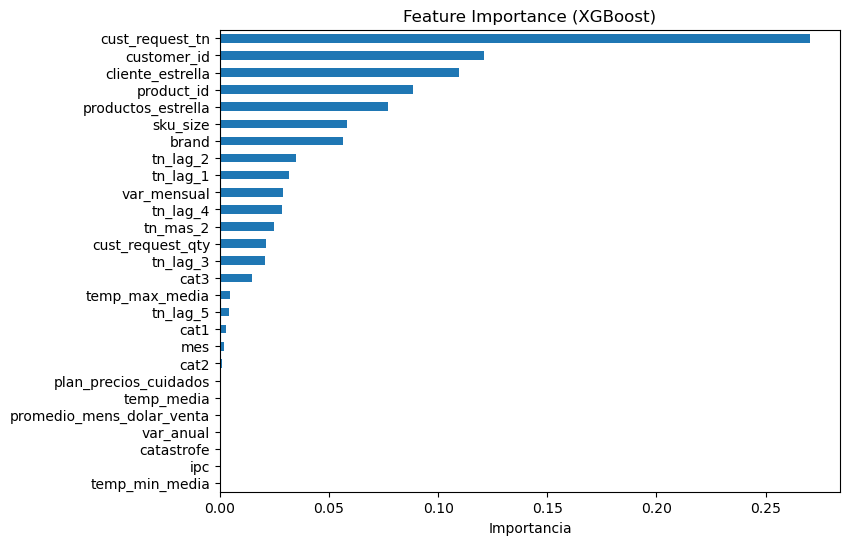

In [18]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# 2) Extrae importancias
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 3) Ordena y grafica
importances = importances.sort_values(ascending=True)
plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importancia')
plt.show()